# Final Project Aviation Dataset

In [1]:
# Load Libraries here
import pandas as pd
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk import FreqDist
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16302/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\16302/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\16302/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\16302/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Dataset

In [2]:
# Load the CSV (adjust path if needed)
df = pd.read_csv("data/ASRS_DBOnline.csv")

## Clean, Tokenize & Normalize

In [3]:
# 2.1 Drop any empty narratives
df = df.dropna(subset=['Report 1'])

# 2.2 Lower-case all text
df['clean_text'] = df['Report 1'].str.lower()

# 2.3 Remove everything except letters & spaces
df['clean_text'] = df['clean_text'].str.replace(r'[^a-z\s]', ' ', regex=True)

# 2.4 Tokenize by splitting on whitespace
df['tokens'] = df['clean_text'].str.split()

# 2.5 Remove stop words and 1-letter tokens
stop = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(
    lambda toks: [t for t in toks if t not in stop and len(t) > 1]
)

# 2.6 Lemmatize for normalization
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(
    lambda toks: [lemmatizer.lemmatize(t) for t in toks]
)

In [4]:
df[['Report 1','clean_text','tokens']].head()

,Report 1,clean_text,tokens
0,Narrative,narrative,[narrative]
1,Was told to line up and wait runway XXR at int...,was told to line up and wait runway xxr at int...,"[told, line, wait, runway, xxr, intersection, ..."
2,A large corporate aircraft taxied with in 5-8 ...,a large corporate aircraft taxied with in ...,"[large, corporate, aircraft, taxied, inch, sta..."
3,GPS Spoofing. Enroute today from ZZZ to SOF; w...,gps spoofing enroute today from zzz to sof w...,"[gps, spoofing, enroute, today, zzz, sof, nort..."
4,Practicing simulated arcs with instrument stud...,practicing simulated arcs with instrument stud...,"[practicing, simulated, arc, instrument, stude..."


## Exploratory Data Analysis

Assessments.1
Human Factors                               2055
Aircraft                                    1751
Weather                                      218
ATC Equipment / Nav Facility / Buildings      70
Environment - Non Weather Related             67
Staffing                                       2
Primary Problem                                1
Name: count, dtype: int64


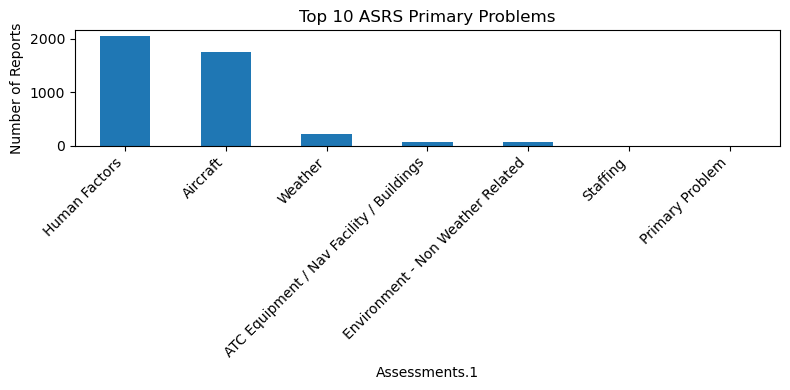

In [5]:
# Count how many reports per problem category
label_counts = df['Assessments.1'].value_counts()

# Display top 10
print(label_counts.head(10))

# Bar plot of top 10
label_counts.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 ASRS Primary Problems")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Human Factors and Aircraft account for nearly 90% of the reports.

count    4164.000000
mean      123.274015
std       104.814701
min         1.000000
25%        57.000000
50%        95.000000
75%       157.000000
max      1102.000000
Name: token_count, dtype: float64


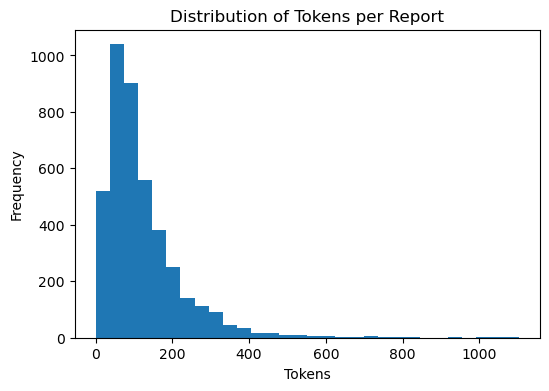

In [6]:
# Compute token counts
df['token_count'] = df['tokens'].map(len)

print(df['token_count'].describe())

df['token_count'].plot(kind='hist', bins=30, figsize=(6,4))
plt.title("Distribution of Tokens per Report")
plt.xlabel("Tokens")
plt.show()

Narratives average about 123 Tokens with a majority falling between 60 and 160 words. This makes sense as radio communications should be "short and sweet". 

             freq
aircraft     9395
zzz          6799
runway       5553
flight       5346
approach     3781
landing      3547
u            3482
engine       3459
time         2868
back         2814
pilot        2797
would        2519
left         2443
altitude     2413
right        2323
atc          2257
control      2187
airport      2084
captain      1932
maintenance  1905


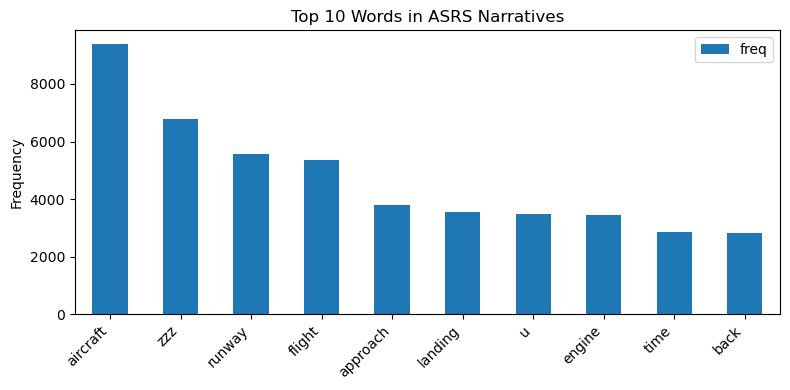

In [7]:
# Flatten all tokens into one list and count
all_counts = Counter()
df['tokens'].map(all_counts.update)

# Convert to DataFrame
freq_df = (
    pd.DataFrame.from_dict(all_counts, orient='index', columns=['freq'])
      .sort_values('freq', ascending=False)
)

# Show top 20
print(freq_df.head(20))

# Plot top 10
freq_df.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 Words in ASRS Narratives")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

ZZZ suggests further cleaning. Aircraft, Runway, Flight, Approach reflect reports consisting of routine aircraft operations and runway interactions. 

# Create Features and Labels - 

### Use preprocessed tokens to create features and use Assessments.1 as the label; build feature words based on frequency

In [8]:
# Build feature words based on frequency
word_cutoff = 5
tokens = [t for tokens in df['tokens'] for t in tokens]
word_dist = FreqDist(tokens)

feature_words = set()
for word, count in word_dist.items():
    if count >= word_cutoff:
        feature_words.add(word)

### Define feature extraction function

In [9]:
def conv_features(text, fw):
    """Convert text to feature dictionary for NLTK Naive Bayes"""
    text_set = set(text.split())
    text_set = text_set.intersection(fw)
    return {word: True for word in text_set}

### Clean data and build feature sets

In [10]:
# Ensure there are no nulls in tokens
df = df.dropna(subset=['tokens'])

# Join token list into a single string
df['joined_tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

# Convert joined tokens into feature sets
featuresets = [
    (conv_features(text, feature_words), label)
    for text, label in zip(df['joined_tokens'], df['Assessments.1'])
]

# Naive Bayes
### Train/Test Split and train Naive Bayes Classifier

In [11]:
import random
random.seed(42)
random.shuffle(featuresets)

test_size = 500
test_set = featuresets[:test_size]
train_set = featuresets[test_size:]

classifier = nltk.NaiveBayesClassifier.train(train_set)

In [12]:
# Accuracy
print("Naive Bayes Accuracy:", nltk.classify.accuracy(classifier, test_set))

# Most informative features
classifier.show_most_informative_features(10)

Naive Bayes Accuracy: 0.006
Most Informative Features
                creating = True           Staffi : Aircra =    852.2 : 1.0
                division = True           Staffi : Human  =    606.3 : 1.0
              procedural = True           Staffi : Human  =    606.3 : 1.0
                 staffed = True           Staffi : Human  =    606.3 : 1.0
                  uneven = True           Staffi : Human  =    606.3 : 1.0
                shortcut = True           Staffi : Aircra =    511.3 : 1.0
             supervision = True           Staffi : Aircra =    511.3 : 1.0
               narrative = True           Primar : Human  =    389.8 : 1.0
                   angry = True           Staffi : Aircra =    306.8 : 1.0
                 handoff = True           Staffi : Aircra =    306.8 : 1.0


### Predict and Compare with actual labels

In [13]:
# Try a few predictions
for i in range(5):
    print(f"Report: {df.iloc[i]['joined_tokens'][:120]}...")
    predicted = classifier.classify(conv_features(df.iloc[i]['joined_tokens'], feature_words))
    actual = df.iloc[i]['Assessments.1']
    print(f"Predicted: {predicted} | Actual: {actual}\n")

Report: narrative...
Predicted: Human Factors | Actual: Primary Problem

Report: told line wait runway xxr intersection cleared take passing kt pic pilot flying rejected takeoff due tow crossing approa...
Predicted: Primary Problem | Actual: Human Factors

Report: large corporate aircraft taxied inch static parked helicopter monitoring ramp situation lack corporate pilot awareness t...
Predicted: Primary Problem | Actual: Human Factors

Report: gps spoofing enroute today zzz sof north egypt approaching lakto intersection filed route ipads showed airplane directly...
Predicted: Primary Problem | Actual: ATC Equipment / Nav Facility / Buildings

Report: practicing simulated arc instrument student aircraft came directly u altitude descended turned avoid aircraft followed c...
Predicted: Primary Problem | Actual: Human Factors



# Logistic Regression
### Vectorize text with TF-IDF

In [14]:
#Filter out rare labels (keep only labels with >= 5 samples)
label_counts = df['Assessments.1'].value_counts()
valid_labels = label_counts[label_counts >= 5].index
df_filtered = df[df['Assessments.1'].isin(valid_labels)].copy()

# Prepare features and labels
X = df_filtered['joined_tokens']
y = df_filtered['Assessments.1']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, stratify=y, random_state=42
)

### Train Logistic Regression

In [15]:
# Train a Logistic Regression classifier on the TF-IDF features
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8691476590636255
                                          precision    recall  f1-score   support

ATC Equipment / Nav Facility / Buildings       0.25      0.07      0.11        14
                                Aircraft       0.88      0.90      0.89       351
       Environment - Non Weather Related       0.00      0.00      0.00        13
                           Human Factors       0.87      0.95      0.90       411
                                 Weather       0.95      0.43      0.59        44

                                accuracy                           0.87       833
                               macro avg       0.59      0.47      0.50       833
                            weighted avg       0.85      0.87      0.85       833



### Determine Most Informative Features

In [16]:
# Extract feature names and model coefficients for interpretation
feature_names = vectorizer.get_feature_names_out()
coefs = lr.coef_

# For multiclass — loop through classes
for idx, class_label in enumerate(lr.classes_):
    top_features = np.argsort(coefs[idx])[-10:]  # Top 10
    print(f"\nTop features for class: {class_label}")
    for feat in reversed(top_features):
        print(f"{feature_names[feat]:>15} : {coefs[idx][feat]:.3f}")



Top features for class: ATC Equipment / Nav Facility / Buildings
            gps : 2.271
      frequency : 1.545
         sector : 1.504
            rnp : 1.097
             il : 1.035
     glideslope : 1.001
          radio : 0.977
     controller : 0.957
            tag : 0.793
       position : 0.739

Top features for class: Aircraft
         engine : 3.343
            zzz : 2.654
    maintenance : 2.295
            qrh : 2.083
        failure : 1.952
           gear : 1.942
       priority : 1.739
       pressure : 1.733
          cabin : 1.719
            rpm : 1.695

Top features for class: Environment - Non Weather Related
            gps : 2.313
           bird : 2.154
       spoofing : 1.193
        terrain : 1.176
         strike : 0.931
        spoofed : 0.903
        jamming : 0.783
         object : 0.747
            mud : 0.716
         relief : 0.682

Top features for class: Human Factors
          drone : 2.000
        traffic : 1.622
            bag : 1.486
          

### Predict and Compare with actual labels

In [17]:
# Predict and display results for 5 random sample reports
sample_texts = df['joined_tokens'].sample(5, random_state=42)

for text in sample_texts:
    X_sample = vectorizer.transform([text])
    pred = lr.predict(X_sample)[0]
    print(f"Text: {text[:100]}...\nPredicted: {pred}\n")

Text: normal takeoff rwy xx zzz climbing around msl student reduced power maximum continuous load required...
Predicted: Aircraft

Text: midfield crossing flying parallel rwy xx parallel heading near miss company aircraft discussed fligh...
Predicted: Human Factors

Text: base given heading join short time later speed knot asked airport instructed clear visual shortly al...
Predicted: Human Factors

Text: single engine piston plane night vfr lost electrical system landed nearest airport largest well lit ...
Predicted: Aircraft

Text: previously launched aircraft heading runway followed clearing aircraft takeoff runway heading cleari...
Predicted: Human Factors



# Support Vector Machine

In [18]:
# Train the SVM model
svm = LinearSVC()
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.8787515006002401

Classification Report:
                                          precision    recall  f1-score   support

ATC Equipment / Nav Facility / Buildings       0.29      0.14      0.19        14
                                Aircraft       0.89      0.91      0.90       351
       Environment - Non Weather Related       0.50      0.15      0.24        13
                           Human Factors       0.88      0.94      0.91       411
                                 Weather       0.96      0.55      0.70        44

                                accuracy                           0.88       833
                               macro avg       0.70      0.54      0.59       833
                            weighted avg       0.87      0.88      0.87       833



### Most informative features

In [19]:
# Extract feature names and model coefficients for SVM interpretation
feature_names = vectorizer.get_feature_names_out()
coefs = svm.coef_

for idx, class_label in enumerate(svm.classes_):
    top10 = np.argsort(coefs[idx])[-10:]
    print(f"\nTop features for class: {class_label}")
    for feat_index in reversed(top10):
        print(f"{feature_names[feat_index]:>15} : {coefs[idx][feat_index]:.3f}")



Top features for class: ATC Equipment / Nav Facility / Buildings
         sector : 1.036
            bgr : 1.025
            rnp : 1.007
     glideslope : 0.995
            cpr : 0.951
            tag : 0.915
            sbn : 0.909
        goggles : 0.863
             il : 0.861
       position : 0.830

Top features for class: Aircraft
        failure : 2.063
         engine : 1.994
            qrh : 1.695
            rpm : 1.611
       pressure : 1.560
            zzz : 1.516
    maintenance : 1.480
        problem : 1.462
          issue : 1.419
           fail : 1.370

Top features for class: Environment - Non Weather Related
           bird : 1.476
        spoofed : 1.315
            mud : 1.130
       spoofing : 1.115
          cairo : 1.055
            gps : 0.885
            orl : 0.812
     electronic : 0.811
        terrain : 0.801
      eastbound : 0.799

Top features for class: Human Factors
          drone : 1.595
     distracted : 1.567
            set : 1.548
          